## Homework 3 : Develop a Named Entity Recognition (NER) tool based on BERT model.


---
> **Student ID:** 313831002


> **Student Name:** Pavan Kumar J | 柯奉煌

> **Course Name:** Recurrent Neural Networks

> **Instructor:** 黃仁竑 


### Import Statements

In [1]:
# # In [1]: Install & Imports
# !pip install torch transformers TorchCRF sklearn tqdm

import os
import re
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from TorchCRF import CRF
from sklearn.metrics import classification_report
from tqdm import tqdm

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)


### Check for GPU

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4090 , device num:0


### Special tags & Model / Dataset definitions

In [3]:
START_TAG = "<START>"
STOP_TAG  = "<STOP>"
PAD_TAG   = "<PAD>"

class SecBERT_BiLSTM_CRF(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, tag_to_ix, dropout=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.hidden_dim = hidden_dim
        self.tag_to_ix  = tag_to_ix
        self.tagset_size= len(tag_to_ix)

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=hidden_dim,
            num_layers=1, bidirectional=True, batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        # CRF
        self.crf = CRF(self.tagset_size, batch_first=True)

    def _get_bert_features(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeds = outputs.last_hidden_state
        lstm_out, _ = self.lstm(embeds)
        lstm_out = self.dropout(lstm_out)
        emissions = self.hidden2tag(lstm_out)
        return emissions

    def forward(self, input_ids, attention_mask, labels=None):
        emissions = self._get_bert_features(input_ids, attention_mask)
        mask = attention_mask.bool()
        if labels is not None:
            crf_labels = labels.clone()
            crf_labels[crf_labels == -100] = 0
            loss = -self.crf(emissions, crf_labels, mask=mask, reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=mask)


class NERDataset(Dataset):
    def __init__(self, sentences, tags, tokenizer, tag_to_ix, max_len=128):
        self.sentences = sentences
        self.tags      = tags
        self.tokenizer = tokenizer
        self.tag_to_ix = tag_to_ix
        self.max_len   = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words    = self.sentences[idx]
        wordtags = self.tags[idx]
        encoding = self.tokenizer(
            words,
            is_split_into_words=True,
            return_offsets_mapping=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids     = encoding['input_ids'].squeeze(0)
        attention_mask= encoding['attention_mask'].squeeze(0)
        word_ids      = encoding.word_ids()

        # build token-level labels
        labels = torch.ones_like(input_ids) * -100
        prev = None
        for i, wid in enumerate(word_ids):
            if wid is None: continue
            if wid != prev:
                labels[i] = self.tag_to_ix[wordtags[wid]]
            prev = wid

        return dict(input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels)


def load_sentences_and_tags(path, zeros=True):
    sents, tags = [], []
    cur_s, cur_t = [], []
    with open(path, encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if cur_s:
                    sents.append(cur_s); tags.append(cur_t)
                    cur_s, cur_t = [], []
            else:
                parts = line.split()
                if 'DOCSTART' in parts[0] or len(parts)<2: continue
                word, tag = parts[0], parts[-1]
                if zeros: word = re.sub(r'\d','0', word)
                cur_s.append(word); cur_t.append(tag)
        if cur_s: sents.append(cur_s); tags.append(cur_t)
    return sents, tags


def create_tag_mapping(all_tags):
    uniq = set(t for seq in all_tags for t in seq)
    uniq.add(PAD_TAG)
    tag_to_ix = {t:i for i,t in enumerate(sorted(uniq))}
    tag_to_ix[START_TAG] = len(tag_to_ix)
    tag_to_ix[STOP_TAG]  = len(tag_to_ix)
    return tag_to_ix


### Helper functions: get_preds_and_labels & train loop

In [4]:
def get_preds_and_labels(model, loader, ix2tag, device):
    model.eval()
    preds, labs = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval"):
            ids  = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            lbls = batch['labels'].to(device)

            batch_preds = model(ids, mask)
            for seq_p, seq_l, seq_m in zip(batch_preds, lbls, mask):
                for p, l, m in zip(seq_p, seq_l.tolist(), seq_m.tolist()):
                    if m==0 or l==-100: continue
                    preds.append(ix2tag[p]); labs.append(ix2tag[l])
    return preds, labs


def train_and_validate(model, train_loader, val_loader,
                       optimizer, scheduler, tag_to_ix,
                       device, epochs=10, model_dir="models"):
    os.makedirs(model_dir, exist_ok=True)
    ix2tag = {i:t for t,i in tag_to_ix.items()}

    history = {'train_loss':[], 'val_prec':[], 'val_rec':[], 'val_f1':[]}
    best_val_f1, best_ckpt = 0.0, None
    print("\n" + "="*50)
    print(f"Training {model.__class__.__name__} model...")  
    print(f"  ↳ Epochs: {epochs}")
    print(f"  ↳ Batch size: {train_loader.batch_size}")
    print(f"  ↳ Tagset size: {len(tag_to_ix)}")
    print(f"  ↳ Training set size: {len(train_loader.dataset)}")
    print(f"  ↳ Validation set size: {len(val_loader.dataset)}")
    print(f"  ↳ Training set: {train_loader.dataset.sentences[0]}")
    print(f"  ↳ Validation set: {val_loader.dataset.sentences[0]}")
    print(f"  ↳ Training set tags: {train_loader.dataset.tags[0]}")
    print(f"  ↳ Validation set tags: {val_loader.dataset.tags[0]}")
    print(f"  ↳ Tag mapping: {tag_to_ix}")
    print(f"  ↳ Tag mapping (inverse): {ix2tag}")
    print(f"  ↳ Optimizer: {optimizer}")
    print("\n" + "="*50)
    print("Training Started...")
    print("="*50)
    for ep in range(1, epochs+1):
        model.train()
        
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {ep}/{epochs} [train]"):
            optimizer.zero_grad()
            loss = model(batch['input_ids'].to(device),
                         batch['attention_mask'].to(device),
                         batch['labels'].to(device))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            optimizer.step(); scheduler.step()
            total_loss += loss.item()

        avg_train = total_loss / len(train_loader)
        history['train_loss'].append(avg_train)

        # validation
        val_p, val_r, val_f = 0,0,0
        preds, labs = get_preds_and_labels(model, val_loader, ix2tag, device)
        rpt = classification_report(labs, preds, output_dict=True, zero_division=0)
        history['val_prec'].append(rpt['weighted avg']['precision'])
        history['val_rec'].append( rpt['weighted avg']['recall'])
        history['val_f1'].append(  rpt['weighted avg']['f1-score'])

        print(f"— Train Loss: {avg_train:.4f}, "
              f"Valid Precision: {history['val_prec'][-1]:.4f}, "
              f"Recall: {history['val_rec'][-1]:.4f}, "
              f"F1 Score: {history['val_f1'][-1]:.4f}")

        # checkpoint if best
        if history['val_f1'][-1] > best_val_f1:
            best_val_f1 = history['val_f1'][-1]
            best_ckpt = os.path.join(model_dir, f"best_f1_epoch{ep}.pt")
            torch.save(dict(
                epoch=ep,
                model_state_dict=model.state_dict(),
                optimizer_state_dict=optimizer.state_dict(),
                scheduler_state_dict=scheduler.state_dict(),
                history=history
            ), best_ckpt)
            print(f"  ↳ Saved new best model (F1: {best_val_f1:.4f})\n")
        else:
            print()

    print(f"Training done — best Val F1: {best_val_f1:.4f} ({best_ckpt})")
    return best_ckpt, history


### Data and model parameters

In [5]:
# Paths
train_p = "./data/train.txt"
val_p = "./data/valid.txt"
test_p = "./data/test.txt"
model_dir = "./models"

# Load & prepare
train_s, train_t = load_sentences_and_tags(train_p)
val_s,   val_t   = load_sentences_and_tags(val_p)
test_s,  test_t  = load_sentences_and_tags(test_p)

tag_to_ix = create_tag_mapping(train_t + val_t + test_t)
tokenizer = AutoTokenizer.from_pretrained("jackaduma/SecBERT")

batch_size = 16
train_ds = NERDataset(train_s, train_t, tokenizer, tag_to_ix)
val_ds   = NERDataset(val_s,   val_t,   tokenizer, tag_to_ix)
test_ds  = NERDataset(test_s,  test_t,  tokenizer, tag_to_ix)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SecBERT_BiLSTM_CRF(
    bert_model_name="jackaduma/SecBERT",
    hidden_dim=128,
    tag_to_ix=tag_to_ix,
    dropout=0.1
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 10
scheduler   = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=100, num_training_steps=total_steps
)

# Train & validate
best_ckpt, history = train_and_validate(
    model, train_loader, val_loader,
    optimizer, scheduler, tag_to_ix,
    device, epochs=10, model_dir=model_dir
)





Training SecBERT_BiLSTM_CRF model...
  ↳ Epochs: 10
  ↳ Batch size: 16
  ↳ Tagset size: 30
  ↳ Training set size: 5251
  ↳ Validation set size: 662
  ↳ Training set: ['The', 'admin@000', 'has', 'largely', 'targeted', 'organizations', 'involved', 'in', 'financial', ',', 'economic', 'and', 'trade', 'policy', ',', 'typically', 'using', 'publicly', 'available', 'RATs', 'such', 'as', 'Poison', 'Ivy', ',', 'as', 'well', 'some', 'non-public', 'backdoors', '.']
  ↳ Validation set: ['We', 'believe', 'that', 'these', 'industries', 'have', 'also', 'been', 'targeted', 'as', 'part', 'of', 'a', 'larger', 'supply-chain', 'attack', 'in', 'order', 'for', 'Orangeworm', 'to', 'get', 'access', 'to', 'their', 'intended', 'victims', 'related', 'to', 'healthcare', '.']
  ↳ Training set tags: ['O', 'B-HackOrg', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Idus', 'O', 'B-Idus', 'O', 'B-Idus', 'I-Idus', 'O', 'O', 'O', 'B-Tool', 'I-Tool', 'I-Tool', 'O', 'O', 'B-Tool', 'I-Tool', 'O', 'O', 'O', 'O', 'B-Tool', 'I-Tool', 'O']


Eval: 100%|██████████| 42/42 [00:01<00:00, 36.25it/s]


— Train Loss: 64.3687, Valid Precision: 0.6623, Recall: 0.8110, F1 Score: 0.7292
  ↳ Saved new best model (F1: 0.7292)



Eval: 100%|██████████| 42/42 [00:01<00:00, 37.60it/s]


— Train Loss: 31.6199, Valid Precision: 0.7098, Recall: 0.8041, F1 Score: 0.7338
  ↳ Saved new best model (F1: 0.7338)



Eval: 100%|██████████| 42/42 [00:01<00:00, 35.24it/s]


— Train Loss: 26.0547, Valid Precision: 0.7519, Recall: 0.8155, F1 Score: 0.7607
  ↳ Saved new best model (F1: 0.7607)



Eval: 100%|██████████| 42/42 [00:01<00:00, 33.96it/s]


— Train Loss: 23.0047, Valid Precision: 0.7609, Recall: 0.8212, F1 Score: 0.7729
  ↳ Saved new best model (F1: 0.7729)



Eval: 100%|██████████| 42/42 [00:01<00:00, 36.69it/s]


— Train Loss: 21.1185, Valid Precision: 0.7965, Recall: 0.8280, F1 Score: 0.7855
  ↳ Saved new best model (F1: 0.7855)



Eval: 100%|██████████| 42/42 [00:01<00:00, 35.58it/s]


— Train Loss: 19.8304, Valid Precision: 0.8054, Recall: 0.8338, F1 Score: 0.7949
  ↳ Saved new best model (F1: 0.7949)



Eval: 100%|██████████| 42/42 [00:01<00:00, 32.52it/s]


— Train Loss: 19.0123, Valid Precision: 0.8098, Recall: 0.8374, F1 Score: 0.8007
  ↳ Saved new best model (F1: 0.8007)



Eval: 100%|██████████| 42/42 [00:01<00:00, 34.37it/s]


— Train Loss: 18.4353, Valid Precision: 0.8225, Recall: 0.8393, F1 Score: 0.8052
  ↳ Saved new best model (F1: 0.8052)



Eval: 100%|██████████| 42/42 [00:01<00:00, 35.31it/s]


— Train Loss: 18.0774, Valid Precision: 0.8278, Recall: 0.8408, F1 Score: 0.8086
  ↳ Saved new best model (F1: 0.8086)



Eval: 100%|██████████| 42/42 [00:01<00:00, 36.74it/s]


— Train Loss: 17.9239, Valid Precision: 0.8276, Recall: 0.8410, F1 Score: 0.8086

Training done — best Val F1: 0.8086 (./models\best_f1_epoch9.pt)


In [6]:
# Load best & test evaluation
print("\nLoading best model for test…")
ckpt = torch.load(best_ckpt, map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)

ix2tag = {i:t for t,i in tag_to_ix.items()}
preds, labs = get_preds_and_labels(model, test_loader, ix2tag, device)
# **NEW**: compute weighted‐avg test P/R/F1
test_rpt = classification_report(labs, preds, output_dict=True, zero_division=0)
test_prec = test_rpt['weighted avg']['precision']
test_rec  = test_rpt['weighted avg']['recall']
test_f1   = test_rpt['weighted avg']['f1-score']
print(f"\nTest Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}")
print("\n" + "="*50)
print(" Detailed Test Set Evaluation ")
print("="*50)
print(classification_report(labs, preds, zero_division=0))

# save report
os.makedirs("model_output", exist_ok=True)
with open("model_output/test_results.txt","w",encoding="utf-8") as f:
    f.write(f"Test Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}\n")
    f.write("\n" + "="*50 + "\n")
    f.write(" Detailed Test Set Evaluation \n")
    f.write("="*50 + "\n")
    f.write(classification_report(labs, preds, zero_division=0))


C:\Users\user\AppData\Local\Temp\ipykernel_76624\1231655060.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_ckpt, map_location=device)



Loading best model for test…


Eval: 100%|██████████| 42/42 [00:01<00:00, 37.36it/s]



Test Precision: 0.8217, Recall: 0.8334, F1: 0.7953

 Detailed Test Set Evaluation 
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00         0
      B-Area       0.69      0.72      0.71       216
       B-Exp       0.93      0.58      0.72       132
  B-Features       0.80      0.03      0.07       116
   B-HackOrg       0.56      0.54      0.55       369
      B-Idus       0.56      0.60      0.58       127
    B-OffAct       0.38      0.08      0.13       150
       B-Org       0.50      0.04      0.07       137
      B-Purp       0.00      0.00      0.00       115
   B-SamFile       0.67      0.01      0.02       248
   B-SecTeam       0.74      0.45      0.56       152
      B-Time       0.86      0.69      0.77       167
      B-Tool       0.53      0.23      0.33       315
       B-Way       0.95      0.35      0.51       100
      I-Area       0.88      0.42      0.57        52
       I-Exp       1.00      0.27      0.42        

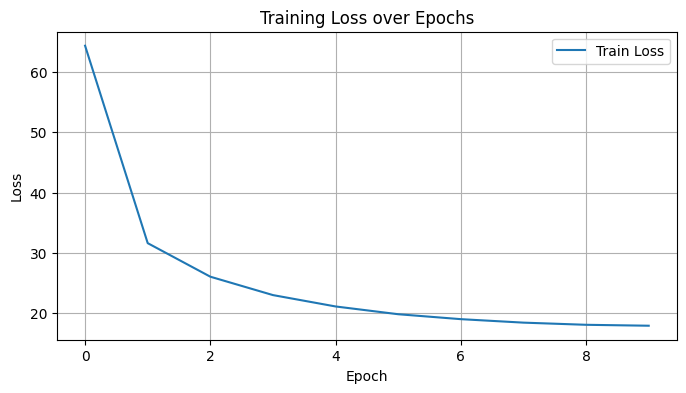

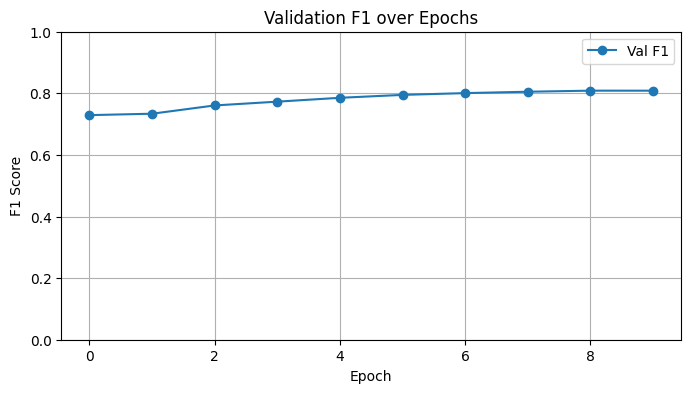

In [7]:
# In [5]: Plot training curves

plt.figure(figsize=(8,4))
plt.plot(history['train_loss'], label="Train Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history['val_f1'], marker='o', label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("F1 Score")
plt.title("Validation F1 over Epochs")
plt.ylim(0,1); plt.legend(); plt.grid(True)
plt.show()
